# Staphylococcus aureus
## Data

In [1]:
import pandas as pd
import numpy as np

The table below contains a list of genimoc features, including coding DNA.

Each feature is solely identified by BRC ID and associated to a protein family referred as PATRIC genus-specific families (PLfams).

In [4]:
saureus_features = pd.read_csv('saureus_genome_features.csv')

In [9]:
saureus_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 21 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Genome                                   10999 non-null  object 
 1   Genome ID                                10999 non-null  float64
 2   Accession                                10999 non-null  object 
 3   BRC ID                                   10999 non-null  object 
 4   RefSeq Locus Tag                         10703 non-null  object 
 5   Alt Locus Tag                            5488 non-null   object 
 6   Feature ID                               10999 non-null  object 
 7   Annotation                               10999 non-null  object 
 8   Feature Type                             10999 non-null  object 
 9   Start                                    10999 non-null  int64  
 10  End                                      10999

Through this table, we extract useful data to map protein families referred by Nguyen et. al.:

In [14]:
plf = saureus_features[['BRC ID', 'PATRIC genus-specific families (PLfams)']].astype("string")

In [15]:
plf.columns = ['BRC_ID', 'PLFam']

In [16]:
plf.set_index('BRC_ID', inplace = True)

In [17]:
plf.head()

,PLFam
BRC_ID,
fig|1241616.6.peg.978,PLF_1279_00000947
fig|1241616.6.peg.979,PLF_1279_00001869
fig|1241616.6.peg.980,PLF_1279_00000303
fig|1241616.6.peg.981,PLF_1279_00000735
fig|1241616.6.peg.982,PLF_1279_00000362


The table below contais pairs of proteins interacting with each other on Staphylococcus aureus protein network, identified by their BRC ID.

In [20]:
saureus_ppi = pd.read_csv('saureus_ppi_patric.csv')

In [21]:
saureus_ppi = saureus_ppi[['Interactor A ID', 'Interactor B ID']].astype("string")

In [22]:
saureus_ppi.columns = ['Interactor_A_ID', 'Interactor_B_ID']

In [23]:
saureus_ppi.head()

,Interactor_A_ID,Interactor_B_ID
0,fig|93061.5.peg.452,fig|93061.5.peg.713
1,fig|93061.5.peg.1920,fig|93061.5.peg.1921
2,fig|93061.5.peg.111,fig|93061.5.peg.119
3,fig|93061.5.peg.112,fig|93061.5.peg.121
4,fig|93061.5.peg.1069,fig|93061.5.peg.1071


The table containing specialty genes relates several genomic features to a relevant property:
 - Essential gene
 - Antibiotic resistance
 - Virulence factor
 - Human homolog
 - Drug target
 - Transporter
 
We are particularly interested on properties associated to antibiotic resistance. Besides genes related to antibiotic resistance themselves, it is possible to have causal relation between virulence factor and bacterial resistance.

In [26]:
sa_specialty_genes = pd.read_csv('saureus_specialty_genes.csv')

In [27]:
sa_specialty_genes = sa_specialty[['BRC ID', 'Property']]

In [28]:
sa_specialty_genes.columns = ['BRC_ID', 'Property']

In [29]:
sa_specialty_genes.set_index('BRC_ID', inplace = True)

In [30]:
sa_specialty_genes.Property.unique()

array(['Antibiotic Resistance', 'Essential Gene', 'Virulence Factor',
       'Human Homolog', 'Drug Target', 'Transporter'], dtype=object)

Next table is listening protein families of 10 experiments (each one with 100 non overlapping protein families) selected from a set of conserved genes and used in the paper of Nguyen et. al.

Each protein family has a feature importance value derived from XGBoost, which means a contribution degree from a protein family given to classificate in resistant/susceptible phenotype.

In [31]:
sa_feature_importance = pd.read_excel('saureus_feature_importance.xlsx') #from the paper

Once the information used in the paper from Nguyen is given in therms of protein families, we need to associate every feature for a corresponding protein family.

Lets  check if every genome feature in the PPI has a associated Patric Local Family:

In [34]:
saureus_ppi['Interactor_A_ID'].isin(plf.index)[saureus_ppi['Interactor_A_ID'].isin(plf.index)==False]

Series([], Name: Interactor_A_ID, dtype: bool)

In [33]:
saureus_ppi['Interactor_B_ID'].isin(plf.index)[saureus_ppi['Interactor_B_ID'].isin(plf.index)==False]

2085    False
Name: Interactor_B_ID, dtype: bool

There is no PLFam associated to the feature fig|93061.5.peg.894 (line 2085, interactor B).

Before ignore this information, lets also check if there is some relevant characteristic related to this feature:

In [48]:
sa_specialty_genes.loc[sa_specialty_genes.index == saureus_ppi['Interactor_B_ID'].loc[2085]]

,Property
BRC_ID,


There is no property associated to this feature, hence, it can be excluded:

In [49]:
saureus_ppi.drop(2085, 0, inplace = True)

C:\Users\BRUNAF~1\AppData\Local\Temp/ipykernel_23444/3658972972.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  saureus_ppi.drop(2085, 0, inplace = True)


Now, lets create a PPI given in terms of Patric Local Families: 

In [53]:
saureus_ppi_plfams = pd.DataFrame([plf.loc[saureus_ppi['Interactor_A_ID']].reset_index()['PLFam'], plf.loc[saureus_ppi['Interactor_B_ID']].reset_index()['PLFam']]).T

In [56]:
saureus_ppi_plfams.columns = ['PLFam_A' , 'PLFam_B']

In [59]:
saureus_ppi_plfams.drop_duplicates(subset=None, keep='first', inplace=True)

In [60]:
saureus_ppi_plfams

,PLFam_A,PLFam_B
0,PLF_1279_00000185,PLF_1279_00000540
1,PLF_1279_00000318,PLF_1279_00000260
2,PLF_1279_00001850,PLF_1279_00001935
3,PLF_1279_00001805,PLF_1279_00002071
4,PLF_1279_00000886,PLF_1279_00000743
...,...,...
4993,PLF_1279_00011116,PLF_1279_00001843
4994,PLF_1279_00001941,PLF_1279_00000562
4996,PLF_1279_00022388,PLF_1279_00002191
4997,PLF_1279_00001442,PLF_1279_00001028


# NetworkX

In [61]:
import networkx as nx
import scipy

This is the network protein interaction in terms of PLFams:

In [62]:
ppi_graph = nx.from_pandas_edgelist(saureus_ppi_plfams, 'PLFam_A' , 'PLFam_B')

In [63]:
ppi_graph.number_of_edges()

4971

### Resistance Genes

In [67]:
sa_specialty_genes[sa_specialty_genes.Property == 'Antibiotic Resistance']

,Property
BRC_ID,
fig|1413510.3.peg.2169,Antibiotic Resistance
fig|93061.5.peg.1154,Antibiotic Resistance
fig|93061.5.peg.2089,Antibiotic Resistance
fig|93061.5.peg.842,Antibiotic Resistance
fig|158879.11.peg.1813,Antibiotic Resistance
...,...
fig|158879.11.peg.2331,Antibiotic Resistance
fig|1241616.6.peg.1396,Antibiotic Resistance
fig|158879.11.peg.647,Antibiotic Resistance


In [72]:
resistance_genes = plf.loc[sa_specialty_genes.loc[sa_specialty_genes.Property == 'Antibiotic Resistance'].index].reset_index()

We need to find which genes related to antibiotic resistance are in the PPI:

In [74]:
resistance_genes_ppi_A = resistance_genes[resistance_genes['PLFam'].isin(saureus_ppi_plfams['PLFam_A'])]
resistance_genes_ppi_B = resistance_genes[resistance_genes['PLFam'].isin(saureus_ppi_plfams['PLFam_B'])]

resistance_genes_ppi = pd.concat([resistance_genes_ppi_A, resistance_genes_ppi_B], axis = 0).drop_duplicates('PLFam')

In [75]:
resistance_genes_ppi.columns = ['BRC_ID', 'PLFam_Resistance']

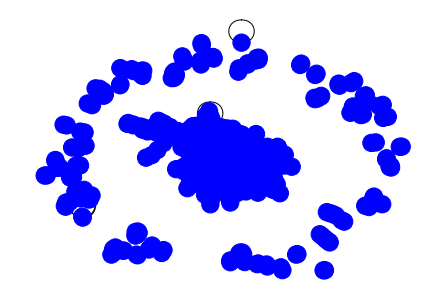

In [80]:
colors = ['red' if node in resistance_genes_ppi['PLFam_Resistance'] else 'blue' for node in ppi_graph.nodes]
nx.draw(ppi_graph, node_color=colors)

### Conserved Genes used for prediction in Nguyen et. al. 2020

We also need to find which conserved genes used to prediction in the paper are in the PPI

In [84]:
sa_paper_in_ppi_A = sa_feature_importance[sa_feature_importance['Protein Family ID'].isin(saureus_ppi_plfams['PLFam_A'])]['Protein Family ID']
sa_paper_in_ppi_B = sa_feature_importance[sa_feature_importance['Protein Family ID'].isin(saureus_ppi_plfams['PLFam_B'])]['Protein Family ID']

sa_conserved_in_ppi = pd.concat([sa_paper_in_ppi_A, sa_paper_in_ppi_B], axis = 0).drop_duplicates()

### Virulence Factors

## Statistics

In [85]:
ppi_graph.degree(resistance_genes_ppi['PLFam_Resistance'])

DegreeView({'PLF_1279_00000401': 23, 'PLF_1279_00004269': 3, 'PLF_1279_00000448': 3, 'PLF_1279_00015910': 6, 'PLF_1279_00001562': 2, 'PLF_1279_00000310': 1, 'PLF_1279_00001271': 18, 'PLF_1279_00000971': 4, 'PLF_1279_00001615': 6, 'PLF_1279_00001556': 7, 'PLF_1279_00000115': 5, 'PLF_1279_00000469': 15, 'PLF_1279_00000085': 8, 'PLF_1279_00000217': 27, 'PLF_1279_00001495': 2, 'PLF_1279_00000489': 4, 'PLF_1279_00000164': 13, 'PLF_1279_00000783': 11, 'PLF_1279_00000570': 33, 'PLF_1279_00001926': 8, 'PLF_1279_00001367': 3, 'PLF_1279_00006163': 9, 'PLF_1279_00000571': 4, 'PLF_1279_00000311': 30, 'PLF_1279_00000484': 9, 'PLF_1279_00000320': 16, 'PLF_1279_00000284': 22, 'PLF_1279_00025736': 8, 'PLF_1279_00000782': 10, 'PLF_1279_00000281': 16, 'PLF_1279_00000173': 13, 'PLF_1279_00000434': 6, 'PLF_1279_00001527': 13, 'PLF_1279_00002044': 7, 'PLF_1279_00000503': 6, 'PLF_1279_00000415': 26, 'PLF_1279_00002337': 1, 'PLF_1279_00000795': 5, 'PLF_1279_00000784': 9, 'PLF_1279_00002294': 2, 'PLF_1279_000

In [294]:
for i in resistance_genes_ppi['PLFam_Resistance']:
    for j in sa_conserved_in_ppi:
        if nx.has_path(ppi_graph, i, j):
            print(nx.shortest_path_length(ppi_graph, i, j))
        

4
3
3
4
4
4
3
4
3
4
4
4
4
3
3
3
4
3
3
2
3
4
2
3
3
1
4
3
4
3
2
3
2
2
1
4
3
2
3
3
3
4
1
1
2
4
3
4
3
4
4
3
3
4
2
4
4
3
5
3
4
3
3
5
5
4
5
3
3
4
5
4
4
2
6
2
3
4
3
3
5
4
5
4
4
4
4
4
4
2
3
3
5
3
3
4
1
6
5
5
1
2
4
2
2
4
4
2
2
3
4
4
3
5
3
4
6
4
3
4
4
3
4
4
3
3
5
3
4
3
3
3
4
4
5
4
3
4
4
4
3
3
5
3
4
4
4
3
3
5
2
3
2
4
4
6
2
3
3
4
5
4
3
3
2
4
3
3
3
3
2
4
3
4
3
3
6
5
3
5
5
3
3
2
4
4
4
4
2
4
3
8
4
5
7
3
3
3
2
3
5
4
4
5
4
4
4
4
4
4
4
3
3
2
3
1
3
3
6
2
4
4
4
4
3
2
4
3
5
5
3
6
3
3
3
3
6
3
4
4
2
3
4
4
5
4
3
2
3
2
4
3
2
2
4
2
3
4
4
4
4
6
3
4
4
4
2
4
3
2
2
2
4
5
4
5
4
5
4
4
3
4
4
3
3
4
3
3
4
5
5
3
3
4
4
3
3
4
3
4
3
5
3
4
4
3
5
3
2
4
1
4
3
4
2
4
3
2
4
4
1
4
4
3
4
5
7
2
3
2
4
4
4
2
5
3
3
4
4
4
5
2
3
4
5
3
5
4
4
5
3
4
5
2
3
4
4
3
2
4
4
4
4
3
3
2
5
5
3
5
4
4
5
2
4
3
4
4
3
3
3
3
3
2
3
4
3
3
4
3
3
3
3
3
5
4
3
4
4
3
4
4
5
3
4
4
3
3
4
5
3
5
3
4
3
5
4
5
3
4
4
3
2
3
3
6
4
2
4
2
4
4
3
4
4
3
3
3
4
4
3
6
3
4
4
4
4
4
3
4
3
2
3
3
3
3
3
3
6
3
6
3
4
4
5
2
4
4
4
2
5
3
4
5
2
4
3
2
2
3
5
4
4
3
3
3
4
4
3
4
2
3
5
2
3
2
3
2
4
5


3
5
3
3
5
5
6
5
5
6
4
5
5
5
4
5
4
5
5
5
3
5
5
4
4
5
4
4
5
5
5
4
5
4
5
4
4
5
5
5
3
6
6
5
4
5
5
4
5
5
4
6
7
5
5
5
4
6
4
4
5
6
4
3
4
6
5
6
6
5
6
5
5
5
7
5
7
5
4
5
5
4
6
5
5
4
4
6
5
6
5
2
4
4
5
4
4
6
4
6
5
7
5
5
3
5
4
5
6
4
5
4
5
5
5
6
4
4
8
3
2
4
6
5
6
4
4
6
6
4
5
3
5
5
7
5
4
5
4
4
6
6
4
4
7
5
5
6
4
5
3
5
4
6
4
5
3
7
5
4
5
5
6
4
5
4
4
4
3
3
6
3
5
5
4
4
5
5
7
6
5
6
5
5
3
4
6
5
4
7
4
4
4
9
5
5
8
5
4
4
5
5
7
6
5
6
7
5
4
6
4
5
6
4
3
4
4
4
4
5
7
4
4
5
6
4
4
4
5
4
6
6
5
3
3
5
5
5
7
5
7
4
5
4
5
3
6
6
4
4
5
4
4
4
5
4
4
6
4
4
4
4
4
6
5
4
5
3
5
5
4
4
4
4
5
5
6
6
4
6
5
5
4
5
6
5
5
5
4
2
4
6
6
5
4
4
5
3
3
5
4
4
5
5
5
7
3
4
6
5
5
3
4
5
6
6
5
5
4
4
5
6
3
5
5
5
5
6
6
5
4
4
6
7
5
5
7
5
5
5
5
6
5
4
5
6
6
4
6
5
4
5
6
5
6
4
5
6
5
3
4
5
5
5
5
5
3
5
7
5
5
4
7
5
6
5
5
4
3
6
5
5
6
4
4
4
6
3
5
5
5
3
5
5
5
4
6
4
4
5
4
5
5
6
6
4
5
4
5
5
5
6
4
6
4
4
5
5
5
6
4
5
5
4
3
3
3
7
5
5
4
4
5
5
6
5
5
4
5
3
6
5
5
7
4
2
4
5
5
6
3
5
4
3
3
3
4
5
4
5
7
4
7
4
7
5
5
4
4
4
5
3
6
3
4
7
4
5
5
4
5
5
6
4
3
4
3
4
4
5
4
5
5
4
5
4
5
5
5
5


6
7
9
6
6
5
7
6
6
6
7
5
6
6
7
6
6
7
5
4
5
7
6
8
8
6
7
6
7
6
6
7
6
7
7
8
6
6
6
8
5
6
7
6
6
6
6
5
7
6
10
6
5
5
7
5
4
7
7
7
6
7
6
8
7
6
4
7
7
5
6
7
6
6
6
5
5
8
7
6
2
6
5
7
7
4
3
4
4
5
5
3
4
3
4
4
4
4
3
5
5
4
4
2
3
4
5
3
3
3
3
4
4
5
5
4
4
3
3
3
3
4
3
4
3
3
6
3
3
4
5
4
4
4
5
5
4
4
3
3
5
5
4
6
3
4
4
4
4
6
4
6
4
5
4
5
5
5
3
5
4
4
5
4
3
4
5
6
2
5
6
4
5
4
3
3
4
3
2
5
6
3
7
3
6
2
3
5
3
4
4
5
3
3
3
5
4
4
4
4
2
7
3
4
3
4
3
5
4
3
5
5
3
3
1
3
4
4
5
6
4
5
4
5
5
4
3
6
4
4
4
4
3
4
5
3
4
3
4
2
6
2
3
4
5
6
4
3
4
3
3
4
5
5
4
4
4
4
4
4
3
7
4
5
6
5
5
3
3
4
4
2
6
2
5
4
8
4
6
7
4
4
5
3
3
6
5
5
6
6
4
4
6
5
4
4
3
4
3
4
3
4
4
7
3
4
3
5
5
2
4
4
4
6
6
3
7
3
4
4
3
7
3
4
4
4
3
4
4
5
5
4
3
4
4
5
4
3
3
5
3
3
4
6
4
5
7
3
4
3
4
3
5
4
4
3
3
4
6
5
5
5
5
4
4
3
3
6
4
3
3
3
3
5
4
6
3
3
2
4
4
4
4
3
4
3
4
4
5
5
4
6
4
3
3
3
4
4
5
3
5
3
3
5
5
3
4
5
2
5
5
6
3
3
4
4
5
4
3
6
4
3
5
5
5
7
3
4
5
4
4
5
5
5
5
4
3
5
3
2
5
5
4
4
4
4
4
5
4
4
3
6
6
5
6
5
5
6
4
4
3
4
5
5
3
3
4
2
4
5
5
4
4
3
5
4
4
4
3
5
4
3
4
5
4
3
5
5
4
4
3
4
4
3
6
4
5
4
5
4

5
5
4
4
4
6
5
5
6
5
5
5
3
4
6
4
6
3
5
5
4
4
5
5
6
4
2
6
5
4
5
4
3
4
5
4
5
6
4
7
4
7
4
4
4
5
5
5
5
4
4
4
5
5
5
6
2
4
8
3
4
5
5
5
6
4
4
5
5
3
5
3
5
4
6
4
4
5
2
4
6
6
5
4
6
4
5
7
5
4
3
4
3
5
4
5
4
6
4
4
4
5
5
3
4
4
4
4
3
4
5
3
4
5
4
4
4
4
7
5
4
5
5
5
3
4
5
5
3
6
4
5
4
8
5
6
7
4
4
5
4
4
6
6
5
6
7
5
5
6
3
5
5
4
3
4
5
4
3
4
7
4
4
5
6
4
4
5
5
4
6
6
4
5
3
4
5
4
7
4
6
5
4
4
4
4
5
6
4
4
4
3
4
3
4
3
5
5
4
4
5
4
4
6
5
4
5
3
4
4
4
4
4
4
5
4
6
6
4
5
4
5
4
4
7
5
5
5
4
2
4
6
6
5
3
4
5
2
3
4
4
5
5
5
3
6
3
4
5
4
4
4
3
4
5
6
4
5
4
4
4
5
4
5
5
4
3
5
7
4
4
5
6
6
5
5
7
4
5
5
5
5
6
4
5
6
6
4
6
6
4
3
5
4
5
3
4
7
3
3
5
4
5
5
5
4
4
4
6
3
3
4
6
5
4
4
5
4
4
6
4
5
6
4
4
5
5
3
5
5
5
4
4
5
4
4
6
4
3
5
3
5
5
5
5
4
4
4
5
4
5
5
4
6
4
4
5
5
5
6
4
4
4
4
3
4
5
7
5
5
5
4
3
3
5
4
5
4
5
4
7
5
4
7
4
4
4
5
5
6
4
5
5
3
3
4
4
5
4
4
6
4
7
5
5
4
4
5
6
2
3
4
6
3
5
7
3
5
4
4
4
4
6
4
3
3
4
4
3
4
4
5
4
3
6
4
4
4
4
5
4
5
3
4
3
4
3
4
5
6
5
4
4
3
3
6
3
5
3
4
3
5
4
4
5
5
1
5
3
5
5
3
5
4
6
4
5
3
5
4
3
3
5
5
4
6
5
5
4
5
4
4
5
5
5
4
4
4
6
4


5
3
3
5
4
5
3
2
4
5
4
4
2
2
3
4
3
4
5
3
6
5
5
2
2
4
3
4
4
4
3
3
3
4
4
4
5
4
3
6
3
3
4
4
3
4
4
2
4
5
2
4
2
3
2
4
4
5
3
2
3
5
4
3
3
4
2
5
5
4
2
3
4
3
4
2
3
3
5
3
3
3
5
5
3
3
4
3
2
4
2
4
3
2
4
3
3
3
3
6
5
4
5
4
4
3
3
4
4
4
5
4
3
3
8
4
5
7
3
3
4
3
4
4
4
4
5
5
3
4
5
3
3
4
3
4
3
4
3
3
2
6
3
4
4
5
4
3
3
4
3
5
6
3
7
4
2
4
2
6
3
5
3
3
3
4
4
4
4
3
3
3
3
4
3
3
2
4
3
3
4
4
4
4
4
3
5
4
4
3
4
3
3
3
3
4
4
4
5
4
3
3
5
3
4
6
3
3
4
3
4
2
5
6
4
3
3
4
3
4
3
3
4
3
3
3
5
4
4
5
3
4
4
3
4
4
5
2
4
4
2
4
5
3
4
4
4
5
4
7
2
3
3
4
4
3
3
5
3
3
4
5
4
4
4
3
4
5
4
4
4
4
3
4
5
4
3
4
5
3
4
4
3
4
3
4
3
3
2
4
3
3
6
5
4
6
2
3
3
4
5
3
4
4
3
3
4
3
4
4
3
4
4
2
3
3
4
5
4
3
5
4
3
4
3
4
4
3
4
3
2
5
5
3
5
3
2
4
4
4
5
4
4
4
4
3
2
3
6
4
3
4
2
3
3
3
3
3
2
3
2
5
4
2
5
3
4
5
5
4
5
4
4
3
3
3
4
3
4
3
3
6
3
6
3
5
3
4
3
4
2
5
3
6
3
4
5
2
4
3
3
2
3
5
4
4
3
4
4
4
3
2
4
3
3
5
2
3
3
4
3
3
5
4
3
1
2
3
3
4
4
4
3
4
5
3
4
2
3
2
3
4
3
4
2
3
3
3
4
3
5
3
3
3
3
4
3
5
1
4
3
3
4
5
3
5
4
5
4
4
3
4
2
3
4
4
3
2
3
4
5
5
3
4
4
4
5
4
5
4
5
3
3
3
4
5
5
6
5
6


8
7
6
7
5
7
7
6
5
6
6
9
5
7
5
8
8
6
7
7
6
8
8
6
9
6
6
7
6
9
6
8
6
6
6
7
7
7
7
6
5
6
6
8
4
5
6
7
6
7
5
7
7
5
7
6
7
6
6
6
7
6
6
5
6
7
7
7
8
5
8
6
8
5
5
8
6
6
5
7
6
5
8
9
5
6
6
6
7
7
6
6
7
6
6
6
8
8
7
8
6
6
7
6
7
7
8
5
7
6
5
7
8
5
7
7
6
8
7
10
5
5
7
7
7
6
5
8
6
6
7
7
7
7
6
6
7
4
7
8
7
5
7
7
7
7
5
6
8
6
7
6
6
7
5
6
6
5
5
7
7
5
8
8
7
9
6
6
6
7
7
7
7
7
6
5
6
7
8
7
6
7
7
6
6
7
7
8
6
6
7
7
6
7
6
7
7
7
6
6
6
7
8
6
8
6
5
7
7
6
8
7
7
7
8
6
5
6
9
7
5
7
5
7
6
6
7
6
7
7
5
8
6
7
8
6
7
7
7
6
8
5
7
6
6
6
5
5
7
6
6
8
6
9
6
8
7
8
6
7
6
7
6
8
7
8
9
6
7
7
6
6
6
8
7
7
6
5
7
7
7
6
7
6
6
8
5
6
5
5
7
6
8
6
6
6
5
4
6
7
7
7
6
7
7
5
7
5
5
4
6
6
7
6
5
5
6
6
7
7
8
7
6
7
6
7
5
7
6
7
5
6
7
6
5
6
7
8
7
7
6
7
5
7
7
7
7
5
6
7
7
8
5
8
7
7
7
8
8
6
8
6
6
6
6
7
8
8
7
9
6
6
6
9
6
6
7
7
6
7
7
6
7
7
9
7
8
6
8
8
9
8
7
6
9
7
8
8
9
6
7
7
8
7
7
8
7
5
6
6
8
8
7
6
4
6
6
7
1
8
8
7
8
6
7
7
7
9
7
7
8
10
8
6
7
7
8
7
7
7
6
6
7
7
8
7
10
6
6
7
8
6
6
7
6
8
6
7
7
9
7
8
5
8
9
7
7
8
7
6
6
6
6
9
8
7
7
6
6
7
8
5
5
5
5
5
5
4
4
4
5
6
5
4
5
6
5
4
4

3
3
4
5
3
5
3
7
4
5
6
2
3
3
3
3
5
5
4
6
6
3
4
6
5
4
4
2
4
3
4
3
3
3
6
3
4
4
5
5
2
3
4
4
5
5
3
7
4
2
4
3
6
1
4
4
4
4
4
3
5
5
3
2
2
3
3
3
3
1
4
3
2
4
5
4
4
6
4
5
4
3
3
4
3
4
3
3
5
4
5
3
4
5
4
4
2
4
6
3
3
4
2
3
4
4
5
4
3
3
5
4
4
4
3
4
3
5
3
5
3
4
5
3
4
4
3
3
4
5
3
5
3
3
4
5
3
4
5
4
5
5
7
3
3
3
4
5
4
3
6
4
3
4
4
5
6
3
4
5
5
4
3
5
4
4
4
5
4
2
4
5
5
4
4
3
4
4
4
3
3
3
5
5
4
6
4
5
6
3
4
3
3
5
4
4
3
4
3
4
5
3
3
3
4
4
3
4
3
3
4
4
3
5
5
3
4
4
4
4
4
4
4
4
3
5
3
5
4
4
4
4
4
4
3
4
4
4
3
4
3
7
5
3
4
3
4
4
3
4
3
3
3
4
5
3
2
4
4
4
5
5
4
6
3
4
4
2
1
4
3
4
3
4
6
4
6
3
5
4
5
4
4
3
4
3
6
4
4
5
3
4
4
2
3
3
3
4
3
3
4
5
4
4
3
5
3
3
5
4
4
4
4
4
2
5
4
3
3
3
3
4
5
4
4
3
2
5
4
3
3
4
3
2
4
4
3
3
2
4
3
4
4
4
2
3
3
3
4
3
5
3
3
2
3
5
4
4
4
5
4
4
4
3
4
2
3
5
3
4
3
3
3
5
4
3
6
4
4
5
5
4
5
6
4
4
3
4
5
4
6
5
7
3
4
3
6
4
4
4
5
5
5
4
4
5
4
4
5
6
3
4
5
6
4
4
5
5
4
3
5
4
4
3
4
4
5
4
6
3
3
4
3
5
6
5
2
3
4
4
5
4
6
5
4
4
5
5
5
4
7
4
4
4
6
4
4
4
6
4
4
4
4
3
4
4
5
5
4
8
4
3
5
5
3
4
4
4
5
4
4
4
5
4
4
3
5
6
5
4
4
4
4
3
5
4
6
6
4
5


In [295]:
for i in resistance_genes_ppi['Resistance Gene Family']:
    for j in resistance_genes_ppi['Resistance Gene Family']:
        if nx.has_path(ppi_graph, i, j):
            print(nx.shortest_path_length(ppi_graph, i, j))

0
4
3
4
4
3
4
4
4
4
3
3
2
4
2
1
4
1
3
5
3
3
2
3
4
1
4
3
2
3
3
3
3
4
2
5
4
3
5
3
8
4
2
4
0
5
5
6
5
5
5
5
5
4
3
3
7
4
4
5
3
5
6
5
5
4
3
4
4
6
5
4
5
5
4
6
4
4
7
4
2
7
4
10
5
2
3
5
0
5
5
5
5
5
5
4
2
4
3
6
3
3
5
2
4
6
4
5
1
4
5
3
5
5
4
2
5
4
5
5
3
6
4
4
5
4
9
5
3
4
5
5
0
4
5
5
5
5
5
5
3
4
4
5
4
4
4
5
5
3
5
4
3
6
4
2
2
3
4
3
5
3
4
4
6
6
5
6
5
6
4
4
0
4
6
5
4
0
5
5
5
5
5
5
5
5
6
6
5
5
5
6
7
4
6
4
5
7
5
4
4
5
4
5
5
5
6
5
8
6
5
7
6
8
6
5
3
5
5
5
5
0
2
2
2
4
3
5
3
4
4
3
1
3
4
2
2
2
4
5
3
3
4
3
3
4
3
1
3
5
2
7
5
5
4
4
8
1
4
4
5
5
5
5
2
0
2
2
4
4
4
3
5
4
3
2
4
4
4
3
1
4
4
4
3
4
4
2
4
4
1
4
5
3
6
5
4
5
4
8
3
4
4
5
5
5
5
2
2
0
1
4
5
4
3
5
4
5
1
4
4
4
2
2
4
4
5
4
4
3
4
4
3
1
4
5
4
7
5
4
6
4
8
3
4
4
5
5
5
5
2
2
1
0
4
5
5
4
5
4
5
1
4
4
4
2
2
4
4
5
4
4
3
4
4
3
1
4
6
4
7
5
4
6
5
8
3
4
4
5
4
5
5
4
4
4
4
0
4
4
4
6
3
4
4
4
5
6
4
4
3
4
5
4
5
5
4
4
4
3
5
5
4
5
5
4
4
5
9
5
4
3
4
2
5
5
3
4
5
5
4
0
3
3
5
3
3
4
2
4
4
4
5
1
3
4
2
3
4
3
2
4
4
4
4
3
6
3
3
5
4
7
3
3
3
3
4
3
5
5
4
4
5
4
3
0
2
6
3
2
5
3
5
5
4
4
3
2
4
3